# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.7954033647506713 -2.845954774912556
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [24]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs[1:])
    rewards = tf.concat(axis=0, values=[rewards, tf.zeros([1])])
    #Qs_labels = targetQs[1:]
    Qs_labels = rewards[:-1] + (0.99*targetQs[1:])
    Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.zeros([1])])
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    #g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    # d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], [-1]),
    #                                                                  labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR #+ d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [25]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [26]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [27]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [28]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [29]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [30]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [31]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/modelR4.ckpt')

Episode:0 meanR:9.0000 rate:0.0180 gloss:0.0557 dloss:0.7331 dlossR:0.7331 dlossQ:0.6921
Episode:1 meanR:9.5000 rate:0.0200 gloss:0.0307 dloss:0.7107 dlossR:0.7107 dlossQ:0.6928
Episode:2 meanR:9.6667 rate:0.0200 gloss:-0.0018 dloss:0.6815 dlossR:0.6815 dlossQ:0.6932
Episode:3 meanR:9.7500 rate:0.0200 gloss:-0.0330 dloss:0.6514 dlossR:0.6514 dlossQ:0.6927
Episode:4 meanR:9.8000 rate:0.0200 gloss:-0.0617 dloss:0.6254 dlossR:0.6254 dlossQ:0.6915
Episode:5 meanR:9.6667 rate:0.0180 gloss:-0.0924 dloss:0.6017 dlossR:0.6017 dlossQ:0.6898
Episode:6 meanR:9.5714 rate:0.0180 gloss:-0.1243 dloss:0.5779 dlossR:0.5779 dlossQ:0.6874
Episode:7 meanR:9.5000 rate:0.0180 gloss:-0.1524 dloss:0.5600 dlossR:0.5600 dlossQ:0.6851
Episode:8 meanR:9.3333 rate:0.0160 gloss:-0.1826 dloss:0.5427 dlossR:0.5427 dlossQ:0.6832
Episode:9 meanR:9.4000 rate:0.0200 gloss:-0.2347 dloss:0.5115 dlossR:0.5115 dlossQ:0.6756
Episode:10 meanR:11.3636 rate:0.0620 gloss:-0.0921 dloss:0.6091 dlossR:0.6091 dlossQ:0.6874
Episode:11

Episode:95 meanR:31.6979 rate:0.0280 gloss:-1.4923 dloss:0.1533 dlossR:0.1533 dlossQ:0.3817
Episode:96 meanR:31.6392 rate:0.0520 gloss:-1.4000 dloss:0.2163 dlossR:0.2163 dlossQ:0.3892
Episode:97 meanR:31.6224 rate:0.0600 gloss:-1.3803 dloss:0.2348 dlossR:0.2348 dlossQ:0.3914
Episode:98 meanR:31.7172 rate:0.0820 gloss:-1.3614 dloss:0.2822 dlossR:0.2822 dlossQ:0.3885
Episode:99 meanR:31.9200 rate:0.1040 gloss:-1.3635 dloss:0.3290 dlossR:0.3290 dlossQ:0.3883
Episode:100 meanR:32.5100 rate:0.1360 gloss:-1.3597 dloss:0.3980 dlossR:0.3980 dlossQ:0.3900
Episode:101 meanR:33.0700 rate:0.1320 gloss:-1.3790 dloss:0.3901 dlossR:0.3901 dlossQ:0.3763
Episode:102 meanR:33.5700 rate:0.1200 gloss:-1.3884 dloss:0.3640 dlossR:0.3640 dlossQ:0.3744
Episode:103 meanR:33.8000 rate:0.0660 gloss:-1.4187 dloss:0.2456 dlossR:0.2456 dlossQ:0.3709
Episode:104 meanR:34.0200 rate:0.0640 gloss:-1.4169 dloss:0.2413 dlossR:0.2413 dlossQ:0.3699
Episode:105 meanR:34.4600 rate:0.1060 gloss:-1.4494 dloss:0.3353 dlossR:0.3

Episode:185 meanR:38.6400 rate:0.0840 gloss:-1.6004 dloss:0.2844 dlossR:0.2844 dlossQ:0.3297
Episode:186 meanR:38.7700 rate:0.0460 gloss:-1.5897 dloss:0.1912 dlossR:0.1912 dlossQ:0.3329
Episode:187 meanR:38.7900 rate:0.0300 gloss:-1.5612 dloss:0.1522 dlossR:0.1522 dlossQ:0.3515
Episode:188 meanR:38.8000 rate:0.0260 gloss:-1.6407 dloss:0.1354 dlossR:0.1354 dlossQ:0.3517
Episode:189 meanR:38.7200 rate:0.0220 gloss:-1.8178 dloss:0.1166 dlossR:0.1166 dlossQ:0.3407
Episode:190 meanR:38.5400 rate:0.0220 gloss:-1.7682 dloss:0.1181 dlossR:0.1181 dlossQ:0.3478
Episode:191 meanR:38.4700 rate:0.0160 gloss:-1.7831 dloss:0.1004 dlossR:0.1004 dlossQ:0.4302
Episode:192 meanR:38.4800 rate:0.0500 gloss:-1.4975 dloss:0.2062 dlossR:0.2062 dlossQ:0.3514
Episode:193 meanR:38.8000 rate:0.1000 gloss:-1.5339 dloss:0.3228 dlossR:0.3228 dlossQ:0.3437
Episode:194 meanR:39.8700 rate:0.2540 gloss:-1.3549 dloss:0.6673 dlossR:0.6673 dlossQ:0.3823
Episode:195 meanR:41.5900 rate:0.3720 gloss:-1.2784 dloss:0.9340 dloss

Episode:283 meanR:53.5200 rate:0.0220 gloss:-1.2439 dloss:0.1733 dlossR:0.1733 dlossQ:0.4491
Episode:284 meanR:52.8300 rate:0.0260 gloss:-1.2704 dloss:0.1787 dlossR:0.1787 dlossQ:0.4344
Episode:285 meanR:52.5200 rate:0.0220 gloss:-1.2837 dloss:0.1660 dlossR:0.1660 dlossQ:0.4438
Episode:286 meanR:52.5100 rate:0.0440 gloss:-1.2073 dloss:0.2271 dlossR:0.2271 dlossQ:0.4374
Episode:287 meanR:52.8200 rate:0.0920 gloss:-1.1078 dloss:0.3216 dlossR:0.3216 dlossQ:0.4628
Episode:288 meanR:53.5500 rate:0.1720 gloss:-1.0966 dloss:0.4586 dlossR:0.4586 dlossQ:0.4654
Episode:289 meanR:53.7900 rate:0.0700 gloss:-1.2079 dloss:0.2762 dlossR:0.2762 dlossQ:0.4313
Episode:290 meanR:54.2700 rate:0.1180 gloss:-1.0010 dloss:0.3694 dlossR:0.3694 dlossQ:0.4929
Episode:291 meanR:54.4900 rate:0.0600 gloss:-1.0318 dloss:0.2748 dlossR:0.2748 dlossQ:0.4838
Episode:292 meanR:54.6600 rate:0.0840 gloss:-1.0602 dloss:0.3096 dlossR:0.3096 dlossQ:0.4738
Episode:293 meanR:54.6500 rate:0.0980 gloss:-1.0814 dloss:0.3316 dloss

Episode:374 meanR:34.4100 rate:0.2180 gloss:-1.6601 dloss:0.6431 dlossR:0.6431 dlossQ:0.2999
Episode:375 meanR:35.5700 rate:0.2600 gloss:-1.6225 dloss:0.7523 dlossR:0.7523 dlossQ:0.3083
Episode:376 meanR:36.1800 rate:0.1520 gloss:-1.7009 dloss:0.4680 dlossR:0.4680 dlossQ:0.2908
Episode:377 meanR:36.9000 rate:0.1720 gloss:-1.6568 dloss:0.5167 dlossR:0.5167 dlossQ:0.3009
Episode:378 meanR:37.9600 rate:0.2360 gloss:-1.5826 dloss:0.6750 dlossR:0.6750 dlossQ:0.3219
Episode:379 meanR:38.6300 rate:0.1540 gloss:-1.6212 dloss:0.4631 dlossR:0.4631 dlossQ:0.3166
Episode:380 meanR:38.9600 rate:0.0840 gloss:-1.6498 dloss:0.2857 dlossR:0.2857 dlossQ:0.3171
Episode:381 meanR:39.3600 rate:0.1000 gloss:-1.6258 dloss:0.3261 dlossR:0.3261 dlossQ:0.3168
Episode:382 meanR:39.7600 rate:0.1020 gloss:-1.6197 dloss:0.3318 dlossR:0.3318 dlossQ:0.3156
Episode:383 meanR:40.2500 rate:0.1200 gloss:-1.6282 dloss:0.3789 dlossR:0.3789 dlossQ:0.3086
Episode:384 meanR:40.2500 rate:0.0260 gloss:-1.5934 dloss:0.1403 dloss

Episode:463 meanR:55.9400 rate:0.4160 gloss:-1.1409 dloss:0.9838 dlossR:0.9838 dlossQ:0.4583
Episode:464 meanR:58.3300 rate:0.5280 gloss:-1.0766 dloss:1.2250 dlossR:1.2250 dlossQ:0.4852
Episode:465 meanR:59.1500 rate:0.2240 gloss:-1.6997 dloss:0.6680 dlossR:0.6680 dlossQ:0.3158
Episode:466 meanR:59.0600 rate:0.0380 gloss:-2.1673 dloss:0.1704 dlossR:0.1704 dlossQ:0.3571
Episode:467 meanR:59.7800 rate:0.2140 gloss:-1.5367 dloss:0.6052 dlossR:0.6052 dlossQ:0.3330
Episode:468 meanR:59.9200 rate:0.1500 gloss:-1.5774 dloss:0.4472 dlossR:0.4472 dlossQ:0.3245
Episode:469 meanR:60.1500 rate:0.1200 gloss:-1.5710 dloss:0.3724 dlossR:0.3724 dlossQ:0.3270
Episode:470 meanR:59.6100 rate:0.1480 gloss:-1.7439 dloss:0.4743 dlossR:0.4743 dlossQ:0.3244
Episode:471 meanR:59.6100 rate:0.1180 gloss:-1.7295 dloss:0.3899 dlossR:0.3899 dlossQ:0.3192
Episode:472 meanR:59.6600 rate:0.1440 gloss:-1.7701 dloss:0.4624 dlossR:0.4624 dlossQ:0.2883
Episode:473 meanR:59.3500 rate:0.0520 gloss:-1.4554 dloss:0.2135 dloss

Episode:552 meanR:49.4300 rate:0.1960 gloss:-1.1727 dloss:0.5146 dlossR:0.5146 dlossQ:0.4497
Episode:553 meanR:50.0600 rate:0.1480 gloss:-1.2003 dloss:0.4259 dlossR:0.4259 dlossQ:0.4396
Episode:554 meanR:50.7400 rate:0.1600 gloss:-1.0522 dloss:0.4467 dlossR:0.4467 dlossQ:0.4789
Episode:555 meanR:51.0200 rate:0.1860 gloss:-1.0413 dloss:0.4940 dlossR:0.4940 dlossQ:0.4813
Episode:556 meanR:50.8600 rate:0.1500 gloss:-1.0437 dloss:0.4341 dlossR:0.4341 dlossQ:0.4790
Episode:557 meanR:51.1800 rate:0.1600 gloss:-0.9703 dloss:0.4501 dlossR:0.4501 dlossQ:0.5023
Episode:558 meanR:51.7700 rate:0.1440 gloss:-1.0097 dloss:0.4236 dlossR:0.4236 dlossQ:0.4906
Episode:559 meanR:51.6700 rate:0.0320 gloss:-1.5182 dloss:0.1670 dlossR:0.1670 dlossQ:0.3601
Episode:560 meanR:51.6300 rate:0.0220 gloss:-1.4748 dloss:0.1455 dlossR:0.1455 dlossQ:0.3939
Episode:561 meanR:51.4000 rate:0.0280 gloss:-1.5871 dloss:0.1525 dlossR:0.1525 dlossQ:0.3643
Episode:562 meanR:50.7700 rate:0.0200 gloss:-1.5289 dloss:0.1371 dloss

Episode:641 meanR:108.6800 rate:0.8900 gloss:0.0701 dloss:1.0834 dlossR:1.0834 dlossQ:0.7898
Episode:642 meanR:113.4600 rate:1.0000 gloss:0.1299 dloss:1.1852 dlossR:1.1852 dlossQ:0.8127
Episode:643 meanR:115.2500 rate:0.4600 gloss:-0.0174 dloss:0.7060 dlossR:0.7060 dlossQ:0.7184
Episode:644 meanR:117.0500 rate:0.5060 gloss:0.0269 dloss:0.7272 dlossR:0.7272 dlossQ:0.7237
Episode:645 meanR:116.3300 rate:0.3360 gloss:0.0285 dloss:0.6583 dlossR:0.6583 dlossQ:0.7063
Episode:646 meanR:117.3000 rate:0.4160 gloss:0.1086 dloss:0.6832 dlossR:0.6832 dlossQ:0.7100
Episode:647 meanR:117.0900 rate:0.3120 gloss:0.0820 dloss:0.6647 dlossR:0.6647 dlossQ:0.7023
Episode:648 meanR:117.9200 rate:0.4400 gloss:0.1631 dloss:0.6900 dlossR:0.6900 dlossQ:0.7088
Episode:649 meanR:117.9300 rate:0.2740 gloss:0.1243 dloss:0.6755 dlossR:0.6755 dlossQ:0.6975
Episode:650 meanR:118.7900 rate:0.3680 gloss:0.1708 dloss:0.6821 dlossR:0.6821 dlossQ:0.7012
Episode:651 meanR:120.0600 rate:0.4280 gloss:0.2051 dloss:0.6893 dlos

Episode:731 meanR:205.0100 rate:0.0860 gloss:-0.2898 dloss:0.5105 dlossR:0.5105 dlossQ:0.6731
Episode:732 meanR:200.5100 rate:0.1000 gloss:-0.2922 dloss:0.5134 dlossR:0.5134 dlossQ:0.6730
Episode:733 meanR:198.1300 rate:0.1200 gloss:-0.3075 dloss:0.5139 dlossR:0.5139 dlossQ:0.6713
Episode:734 meanR:196.7600 rate:0.1060 gloss:-0.3337 dloss:0.4993 dlossR:0.4993 dlossQ:0.6669
Episode:735 meanR:192.4400 rate:0.0640 gloss:-0.3778 dloss:0.4654 dlossR:0.4654 dlossQ:0.6590
Episode:736 meanR:188.6000 rate:0.0560 gloss:-0.4181 dloss:0.4449 dlossR:0.4449 dlossQ:0.6514
Episode:737 meanR:186.6100 rate:0.1140 gloss:-0.3970 dloss:0.4808 dlossR:0.4808 dlossQ:0.6562
Episode:738 meanR:183.8500 rate:0.0840 gloss:-0.4342 dloss:0.4526 dlossR:0.4526 dlossQ:0.6485
Episode:739 meanR:181.7300 rate:0.0540 gloss:-0.4844 dloss:0.4168 dlossR:0.4168 dlossQ:0.6375
Episode:740 meanR:178.7500 rate:0.0740 gloss:-0.4850 dloss:0.4288 dlossR:0.4288 dlossQ:0.6377
Episode:741 meanR:174.5800 rate:0.0560 gloss:-0.5394 dloss:0

Episode:820 meanR:72.7300 rate:0.1760 gloss:-1.0362 dloss:0.4668 dlossR:0.4668 dlossQ:0.4926
Episode:821 meanR:71.6700 rate:0.1080 gloss:-1.1305 dloss:0.3513 dlossR:0.3513 dlossQ:0.4716
Episode:822 meanR:71.6200 rate:0.2120 gloss:-1.0089 dloss:0.5261 dlossR:0.5261 dlossQ:0.5004
Episode:823 meanR:72.0300 rate:0.2160 gloss:-1.0012 dloss:0.5325 dlossR:0.5325 dlossQ:0.5029
Episode:824 meanR:71.0200 rate:0.2140 gloss:-1.0120 dloss:0.5300 dlossR:0.5300 dlossQ:0.4976
Episode:825 meanR:71.4800 rate:0.2380 gloss:-0.9871 dloss:0.5696 dlossR:0.5696 dlossQ:0.5072
Episode:826 meanR:71.9400 rate:0.2380 gloss:-1.0008 dloss:0.5714 dlossR:0.5714 dlossQ:0.5012
Episode:827 meanR:73.4500 rate:0.3960 gloss:-0.8417 dloss:0.8230 dlossR:0.8230 dlossQ:0.5575
Episode:828 meanR:74.2000 rate:0.2540 gloss:-0.9928 dloss:0.5990 dlossR:0.5990 dlossQ:0.5043
Episode:829 meanR:74.7200 rate:0.2700 gloss:-0.9565 dloss:0.6229 dlossR:0.6229 dlossQ:0.5141
Episode:830 meanR:75.2400 rate:0.1740 gloss:-1.0589 dloss:0.4631 dloss

Episode:909 meanR:89.3200 rate:0.0700 gloss:-0.9592 dloss:0.3064 dlossR:0.3064 dlossQ:0.5167
Episode:910 meanR:90.0700 rate:0.1960 gloss:-0.8439 dloss:0.4945 dlossR:0.4945 dlossQ:0.5450
Episode:911 meanR:90.2400 rate:0.0740 gloss:-1.0603 dloss:0.3054 dlossR:0.3054 dlossQ:0.4998
Episode:912 meanR:90.6100 rate:0.1020 gloss:-0.9533 dloss:0.3538 dlossR:0.3538 dlossQ:0.5152
Episode:913 meanR:95.2200 rate:0.9940 gloss:-0.2748 dloss:1.6118 dlossR:1.6118 dlossQ:0.7851
Episode:914 meanR:93.7300 rate:0.0500 gloss:-1.0561 dloss:0.2590 dlossR:0.2590 dlossQ:0.4919
Episode:915 meanR:92.6700 rate:0.1140 gloss:-0.9929 dloss:0.3708 dlossR:0.3708 dlossQ:0.5099
Episode:916 meanR:91.7700 rate:0.2120 gloss:-0.8721 dloss:0.5192 dlossR:0.5192 dlossQ:0.5405
Episode:917 meanR:90.5700 rate:0.0780 gloss:-1.1588 dloss:0.3045 dlossR:0.3045 dlossQ:0.4789
Episode:918 meanR:89.4800 rate:0.0320 gloss:-1.1856 dloss:0.2065 dlossR:0.2065 dlossQ:0.4628
Episode:919 meanR:88.5000 rate:0.0440 gloss:-1.0902 dloss:0.2424 dloss

Episode:998 meanR:88.4700 rate:0.0840 gloss:-0.9934 dloss:0.3213 dlossR:0.3213 dlossQ:0.5021
Episode:999 meanR:88.4200 rate:0.0380 gloss:-1.2172 dloss:0.2153 dlossR:0.2153 dlossQ:0.4414
Episode:1000 meanR:87.2100 rate:0.0260 gloss:-1.2697 dloss:0.1843 dlossR:0.1843 dlossQ:0.4440
Episode:1001 meanR:86.4600 rate:0.0860 gloss:-1.0380 dloss:0.3282 dlossR:0.3282 dlossQ:0.4916
Episode:1002 meanR:86.0400 rate:0.0500 gloss:-1.2106 dloss:0.2392 dlossR:0.2392 dlossQ:0.4509
Episode:1003 meanR:85.7600 rate:0.0220 gloss:-1.5205 dloss:0.1559 dlossR:0.1559 dlossQ:0.4152
Episode:1004 meanR:85.8900 rate:0.1560 gloss:-1.0427 dloss:0.4396 dlossR:0.4396 dlossQ:0.4880
Episode:1005 meanR:87.5500 rate:0.4880 gloss:-0.5425 dloss:0.8802 dlossR:0.8802 dlossQ:0.6445
Episode:1006 meanR:92.0000 rate:1.0000 gloss:-0.1355 dloss:1.4803 dlossR:1.4803 dlossQ:0.7956
Episode:1007 meanR:96.2500 rate:1.0000 gloss:-0.0675 dloss:1.4012 dlossR:1.4012 dlossQ:0.8035
Episode:1008 meanR:100.0900 rate:1.0000 gloss:0.0205 dloss:1.3

Episode:1085 meanR:110.4900 rate:1.0000 gloss:0.3215 dloss:1.0226 dlossR:1.0226 dlossQ:0.7662
Episode:1086 meanR:114.5000 rate:1.0000 gloss:0.3083 dloss:1.0473 dlossR:1.0473 dlossQ:0.7510
Episode:1087 meanR:119.3200 rate:1.0000 gloss:0.3744 dloss:0.9861 dlossR:0.9861 dlossQ:0.7416
Episode:1088 meanR:122.7400 rate:0.7160 gloss:0.2498 dloss:0.8244 dlossR:0.8244 dlossQ:0.7017
Episode:1089 meanR:125.6500 rate:0.6060 gloss:0.2275 dloss:0.7703 dlossR:0.7703 dlossQ:0.6877
Episode:1090 meanR:128.5700 rate:0.6060 gloss:0.3319 dloss:0.7302 dlossR:0.7302 dlossQ:0.6899
Episode:1091 meanR:129.5100 rate:0.3300 gloss:0.0992 dloss:0.6972 dlossR:0.6972 dlossQ:0.6747
Episode:1092 meanR:126.3200 rate:0.3620 gloss:0.0802 dloss:0.7072 dlossR:0.7072 dlossQ:0.6692
Episode:1093 meanR:123.1100 rate:0.3580 gloss:0.1099 dloss:0.7081 dlossR:0.7081 dlossQ:0.6697
Episode:1094 meanR:123.5400 rate:0.1900 gloss:-0.1104 dloss:0.6414 dlossR:0.6414 dlossQ:0.6559
Episode:1095 meanR:123.9900 rate:0.1900 gloss:-0.2648 dloss

Episode:1172 meanR:127.8000 rate:1.0000 gloss:0.4604 dloss:0.8872 dlossR:0.8872 dlossQ:0.7516
Episode:1173 meanR:131.9400 rate:1.0000 gloss:0.5283 dloss:0.8275 dlossR:0.8275 dlossQ:0.7372
Episode:1174 meanR:136.1400 rate:0.9520 gloss:0.5193 dloss:0.7987 dlossR:0.7987 dlossQ:0.7270
Episode:1175 meanR:138.4700 rate:0.5000 gloss:0.1467 dloss:0.7151 dlossR:0.7151 dlossQ:0.7075
Episode:1176 meanR:141.4200 rate:0.6380 gloss:0.2956 dloss:0.7398 dlossR:0.7398 dlossQ:0.7097
Episode:1177 meanR:143.6700 rate:0.4760 gloss:0.1175 dloss:0.7118 dlossR:0.7118 dlossQ:0.7038
Episode:1178 meanR:145.3300 rate:0.3540 gloss:0.0543 dloss:0.6759 dlossR:0.6759 dlossQ:0.6943
Episode:1179 meanR:146.8300 rate:0.3180 gloss:0.0779 dloss:0.6726 dlossR:0.6726 dlossQ:0.6925
Episode:1180 meanR:148.0900 rate:0.2720 gloss:0.0075 dloss:0.6515 dlossR:0.6515 dlossQ:0.6926
Episode:1181 meanR:149.4400 rate:0.2980 gloss:-0.0098 dloss:0.6561 dlossR:0.6561 dlossQ:0.6896
Episode:1182 meanR:144.5500 rate:0.0220 gloss:-0.7981 dloss

Episode:1259 meanR:187.1600 rate:0.7680 gloss:0.5979 dloss:0.7249 dlossR:0.7249 dlossQ:0.6412
Episode:1260 meanR:186.7700 rate:0.1560 gloss:-0.6747 dloss:0.4631 dlossR:0.4631 dlossQ:0.5952
Episode:1261 meanR:187.7400 rate:0.6980 gloss:0.8518 dloss:0.6684 dlossR:0.6684 dlossQ:0.5635
Episode:1262 meanR:189.6500 rate:0.6140 gloss:0.5782 dloss:0.7049 dlossR:0.7049 dlossQ:0.6337
Episode:1263 meanR:192.5900 rate:0.9380 gloss:0.9500 dloss:0.5431 dlossR:0.5431 dlossQ:0.5792
Episode:1264 meanR:191.0800 rate:0.6980 gloss:0.5873 dloss:0.7227 dlossR:0.7227 dlossQ:0.6316
Episode:1265 meanR:193.6700 rate:0.5980 gloss:0.7165 dloss:0.7125 dlossR:0.7125 dlossQ:0.5954
Episode:1266 meanR:194.4000 rate:0.2100 gloss:-0.6671 dloss:0.5274 dlossR:0.5274 dlossQ:0.5977
Episode:1267 meanR:190.2900 rate:0.1780 gloss:-0.5818 dloss:0.5017 dlossR:0.5017 dlossQ:0.6144
Episode:1268 meanR:187.1400 rate:0.3700 gloss:0.4447 dloss:0.7674 dlossR:0.7674 dlossQ:0.6399
Episode:1269 meanR:187.9300 rate:0.2120 gloss:-0.5523 dlo

Episode:1355 meanR:129.0100 rate:0.0200 gloss:-1.6764 dloss:0.1327 dlossR:0.1327 dlossQ:0.3789
Episode:1356 meanR:125.4400 rate:0.0180 gloss:-1.7254 dloss:0.1237 dlossR:0.1237 dlossQ:0.4002
Episode:1357 meanR:122.7100 rate:0.0200 gloss:-1.7496 dloss:0.1281 dlossR:0.1281 dlossQ:0.3965
Episode:1358 meanR:121.8100 rate:0.4580 gloss:-0.5211 dloss:0.8261 dlossR:0.8261 dlossQ:0.6447
Episode:1359 meanR:118.1100 rate:0.0280 gloss:-2.0959 dloss:0.1359 dlossR:0.1359 dlossQ:0.3166
Episode:1360 meanR:117.5700 rate:0.0480 gloss:-1.8507 dloss:0.1999 dlossR:0.1999 dlossQ:0.3434
Episode:1361 meanR:114.3900 rate:0.0620 gloss:-1.6414 dloss:0.2407 dlossR:0.2407 dlossQ:0.3692
Episode:1362 meanR:112.3000 rate:0.1960 gloss:-1.3282 dloss:0.5293 dlossR:0.5293 dlossQ:0.3998
Episode:1363 meanR:109.8900 rate:0.4560 gloss:-0.7811 dloss:0.9269 dlossR:0.9269 dlossQ:0.5723
Episode:1364 meanR:106.8200 rate:0.0840 gloss:-1.2555 dloss:0.2987 dlossR:0.2987 dlossQ:0.4317
Episode:1365 meanR:104.2100 rate:0.0760 gloss:-1.3

Episode:1442 meanR:156.9700 rate:0.4980 gloss:0.1906 dloss:0.7092 dlossR:0.7092 dlossQ:0.7024
Episode:1443 meanR:157.9200 rate:0.2280 gloss:-0.5759 dloss:0.5444 dlossR:0.5444 dlossQ:0.6215
Episode:1444 meanR:160.3900 rate:0.5160 gloss:0.2305 dloss:0.7100 dlossR:0.7100 dlossQ:0.7031
Episode:1445 meanR:160.5800 rate:0.1260 gloss:-0.6716 dloss:0.4340 dlossR:0.4340 dlossQ:0.5940
Episode:1446 meanR:162.5100 rate:0.4720 gloss:0.1776 dloss:0.7049 dlossR:0.7049 dlossQ:0.7014
Episode:1447 meanR:164.9600 rate:0.5660 gloss:0.1793 dloss:0.7391 dlossR:0.7391 dlossQ:0.7109
Episode:1448 meanR:165.5100 rate:0.1840 gloss:-0.5939 dloss:0.5000 dlossR:0.5000 dlossQ:0.6147
Episode:1449 meanR:167.2100 rate:0.3620 gloss:0.0856 dloss:0.6789 dlossR:0.6789 dlossQ:0.6949
Episode:1450 meanR:169.0700 rate:0.3920 gloss:0.0640 dloss:0.6839 dlossR:0.6839 dlossQ:0.6979
Episode:1451 meanR:171.3500 rate:0.4820 gloss:0.0854 dloss:0.7168 dlossR:0.7168 dlossQ:0.7046
Episode:1452 meanR:173.3200 rate:0.4140 gloss:0.0372 dlos

Episode:1530 meanR:163.6000 rate:0.4800 gloss:0.1625 dloss:0.7076 dlossR:0.7076 dlossQ:0.7040
Episode:1531 meanR:163.6200 rate:0.6060 gloss:0.2333 dloss:0.7506 dlossR:0.7506 dlossQ:0.7041
Episode:1532 meanR:163.9200 rate:0.1420 gloss:-0.9769 dloss:0.4138 dlossR:0.4138 dlossQ:0.5101
Episode:1533 meanR:164.5400 rate:0.1960 gloss:-0.8765 dloss:0.4976 dlossR:0.4976 dlossQ:0.5385
Episode:1534 meanR:164.2800 rate:0.1240 gloss:-1.0086 dloss:0.3849 dlossR:0.3849 dlossQ:0.5006
Episode:1535 meanR:164.9700 rate:0.7200 gloss:0.2708 dloss:0.8122 dlossR:0.8122 dlossQ:0.6959
Episode:1536 meanR:164.0800 rate:0.1180 gloss:-1.0308 dloss:0.3748 dlossR:0.3748 dlossQ:0.4927
Episode:1537 meanR:159.9700 rate:0.1780 gloss:-0.9196 dloss:0.4722 dlossR:0.4722 dlossQ:0.5246
Episode:1538 meanR:162.4500 rate:0.9980 gloss:0.4654 dloss:0.8894 dlossR:0.8894 dlossQ:0.7214
Episode:1539 meanR:162.6400 rate:0.5820 gloss:0.2522 dloss:0.7337 dlossR:0.7337 dlossQ:0.7009
Episode:1540 meanR:166.2600 rate:0.9280 gloss:0.5316 dl

Episode:1618 meanR:237.2800 rate:0.1400 gloss:-0.1323 dloss:0.5592 dlossR:0.5592 dlossQ:0.6853
Episode:1619 meanR:238.2500 rate:0.2180 gloss:-0.0800 dloss:0.6038 dlossR:0.6038 dlossQ:0.6965
Episode:1620 meanR:234.2000 rate:0.1080 gloss:-0.2511 dloss:0.4828 dlossR:0.4828 dlossQ:0.6574
Episode:1621 meanR:233.1500 rate:0.3160 gloss:-0.0206 dloss:0.6500 dlossR:0.6500 dlossQ:0.7101
Episode:1622 meanR:230.8400 rate:0.0860 gloss:-0.2718 dloss:0.4539 dlossR:0.4539 dlossQ:0.6463
Episode:1623 meanR:226.3500 rate:0.1020 gloss:-0.2493 dloss:0.4741 dlossR:0.4741 dlossQ:0.6527
Episode:1624 meanR:223.7500 rate:0.0860 gloss:-0.3573 dloss:0.4153 dlossR:0.4153 dlossQ:0.6191
Episode:1625 meanR:221.7400 rate:0.0780 gloss:-0.3810 dloss:0.3966 dlossR:0.3966 dlossQ:0.6089
Episode:1626 meanR:219.7400 rate:0.1000 gloss:-0.3901 dloss:0.4200 dlossR:0.4200 dlossQ:0.6129
Episode:1627 meanR:219.5200 rate:0.0880 gloss:-0.4416 dloss:0.3935 dlossR:0.3935 dlossQ:0.5963
Episode:1628 meanR:217.6600 rate:0.1340 gloss:-0.4

Episode:1712 meanR:83.5900 rate:0.0540 gloss:-1.5332 dloss:0.2184 dlossR:0.2184 dlossQ:0.3628
Episode:1713 meanR:82.3900 rate:0.0580 gloss:-1.5080 dloss:0.2302 dlossR:0.2302 dlossQ:0.3682
Episode:1714 meanR:81.1300 rate:0.0420 gloss:-1.7658 dloss:0.1766 dlossR:0.1766 dlossQ:0.3201
Episode:1715 meanR:80.2300 rate:0.0600 gloss:-1.6362 dloss:0.2286 dlossR:0.2286 dlossQ:0.3368
Episode:1716 meanR:79.0000 rate:0.0760 gloss:-1.6014 dloss:0.2705 dlossR:0.2705 dlossQ:0.3435
Episode:1717 meanR:78.0600 rate:0.0720 gloss:-1.6305 dloss:0.2601 dlossR:0.2601 dlossQ:0.3376
Episode:1718 meanR:77.8600 rate:0.1000 gloss:-1.5867 dloss:0.3297 dlossR:0.3297 dlossQ:0.3528
Episode:1719 meanR:77.3400 rate:0.1140 gloss:-1.1542 dloss:0.3557 dlossR:0.3557 dlossQ:0.4515
Episode:1720 meanR:77.3700 rate:0.1140 gloss:-1.1478 dloss:0.3569 dlossR:0.3569 dlossQ:0.4502
Episode:1721 meanR:76.3400 rate:0.1100 gloss:-1.1028 dloss:0.3514 dlossR:0.3514 dlossQ:0.4643
Episode:1722 meanR:76.5500 rate:0.1280 gloss:-1.0393 dloss:0

Episode:1803 meanR:30.5900 rate:0.0600 gloss:-1.6148 dloss:0.2287 dlossR:0.2287 dlossQ:0.3563
Episode:1804 meanR:30.8700 rate:0.1620 gloss:-1.3207 dloss:0.4582 dlossR:0.4582 dlossQ:0.4016
Episode:1805 meanR:31.0900 rate:0.1420 gloss:-1.2976 dloss:0.4153 dlossR:0.4153 dlossQ:0.4127
Episode:1806 meanR:31.0800 rate:0.0460 gloss:-1.5600 dloss:0.2026 dlossR:0.2026 dlossQ:0.3605
Episode:1807 meanR:31.2100 rate:0.0740 gloss:-1.5195 dloss:0.2673 dlossR:0.2673 dlossQ:0.3738
Episode:1808 meanR:31.3000 rate:0.0620 gloss:-1.6147 dloss:0.2382 dlossR:0.2382 dlossQ:0.3625
Episode:1809 meanR:31.4000 rate:0.0540 gloss:-1.6265 dloss:0.2155 dlossR:0.2155 dlossQ:0.3494
Episode:1810 meanR:31.3800 rate:0.0320 gloss:-1.7560 dloss:0.1517 dlossR:0.1517 dlossQ:0.3379
Episode:1811 meanR:31.3800 rate:0.0300 gloss:-1.9117 dloss:0.1396 dlossR:0.1396 dlossQ:0.3189
Episode:1812 meanR:31.2300 rate:0.0240 gloss:-1.9770 dloss:0.1200 dlossR:0.1200 dlossQ:0.3473
Episode:1813 meanR:31.0700 rate:0.0260 gloss:-1.8360 dloss:0

Episode:1895 meanR:40.8000 rate:0.2480 gloss:-0.8915 dloss:0.5850 dlossR:0.5850 dlossQ:0.5307
Episode:1896 meanR:40.3400 rate:0.1660 gloss:-1.1374 dloss:0.4544 dlossR:0.4544 dlossQ:0.4499
Episode:1897 meanR:40.3700 rate:0.1020 gloss:-1.4112 dloss:0.3306 dlossR:0.3306 dlossQ:0.3761
Episode:1898 meanR:40.1600 rate:0.0500 gloss:-1.7420 dloss:0.1981 dlossR:0.1981 dlossQ:0.3012
Episode:1899 meanR:39.8200 rate:0.0220 gloss:-1.9224 dloss:0.1205 dlossR:0.1205 dlossQ:0.3711
Episode:1900 meanR:39.6600 rate:0.0220 gloss:-2.0327 dloss:0.1142 dlossR:0.1142 dlossQ:0.3569
Episode:1901 meanR:39.5300 rate:0.0260 gloss:-1.8701 dloss:0.1305 dlossR:0.1305 dlossQ:0.3329
Episode:1902 meanR:39.5900 rate:0.0480 gloss:-1.7063 dloss:0.1932 dlossR:0.1932 dlossQ:0.3200
Episode:1903 meanR:39.6000 rate:0.0620 gloss:-1.6183 dloss:0.2312 dlossR:0.2312 dlossQ:0.3434
Episode:1904 meanR:39.1400 rate:0.0700 gloss:-1.5584 dloss:0.2525 dlossR:0.2525 dlossQ:0.3591
Episode:1905 meanR:38.8500 rate:0.0840 gloss:-1.5106 dloss:0

Episode:1983 meanR:63.1900 rate:0.2920 gloss:-0.6429 dloss:0.6210 dlossR:0.6210 dlossQ:0.6082
Episode:1984 meanR:63.5000 rate:0.2580 gloss:-0.5720 dloss:0.5777 dlossR:0.5777 dlossQ:0.6244
Episode:1985 meanR:63.5900 rate:0.1620 gloss:-0.8625 dloss:0.4571 dlossR:0.4571 dlossQ:0.5465
Episode:1986 meanR:64.7100 rate:0.2760 gloss:-0.5409 dloss:0.5971 dlossR:0.5971 dlossQ:0.6312
Episode:1987 meanR:65.2000 rate:0.2780 gloss:-0.6640 dloss:0.6050 dlossR:0.6050 dlossQ:0.5996
Episode:1988 meanR:65.7700 rate:0.2200 gloss:-0.8190 dloss:0.5309 dlossR:0.5309 dlossQ:0.5552
Episode:1989 meanR:67.2700 rate:0.3180 gloss:-0.5308 dloss:0.6382 dlossR:0.6382 dlossQ:0.6376
Episode:1990 meanR:68.6000 rate:0.2840 gloss:-0.6671 dloss:0.6086 dlossR:0.6086 dlossQ:0.6000
Episode:1991 meanR:70.0100 rate:0.3020 gloss:-0.6260 dloss:0.6290 dlossR:0.6290 dlossQ:0.6104
Episode:1992 meanR:70.9000 rate:0.1980 gloss:-0.7074 dloss:0.5022 dlossR:0.5022 dlossQ:0.5846
Episode:1993 meanR:71.5900 rate:0.1600 gloss:-0.7628 dloss:0

Episode:2074 meanR:77.0700 rate:0.0560 gloss:-1.2918 dloss:0.2387 dlossR:0.2387 dlossQ:0.4301
Episode:2075 meanR:77.5900 rate:0.4180 gloss:-1.0366 dloss:0.9434 dlossR:0.9434 dlossQ:0.4982
Episode:2076 meanR:76.3000 rate:0.1160 gloss:-1.3622 dloss:0.3586 dlossR:0.3586 dlossQ:0.3878
Episode:2077 meanR:75.2800 rate:0.1820 gloss:-1.3772 dloss:0.5094 dlossR:0.5094 dlossQ:0.3936
Episode:2078 meanR:73.2800 rate:0.0240 gloss:-2.0567 dloss:0.1265 dlossR:0.1265 dlossQ:0.3190
Episode:2079 meanR:70.4400 rate:0.0220 gloss:-2.1779 dloss:0.1194 dlossR:0.1194 dlossQ:0.3674
Episode:2080 meanR:69.7400 rate:0.1180 gloss:-1.3308 dloss:0.3625 dlossR:0.3625 dlossQ:0.3946
Episode:2081 meanR:69.3700 rate:0.2140 gloss:-0.8394 dloss:0.5307 dlossR:0.5307 dlossQ:0.5547
Episode:2082 meanR:69.4800 rate:0.2780 gloss:-0.8324 dloss:0.6288 dlossR:0.6288 dlossQ:0.5537
Episode:2083 meanR:68.2700 rate:0.0500 gloss:-1.5172 dloss:0.2112 dlossR:0.2112 dlossQ:0.3981
Episode:2084 meanR:67.1500 rate:0.0340 gloss:-1.7019 dloss:0

Episode:2168 meanR:66.0100 rate:0.3060 gloss:-0.8225 dloss:0.6638 dlossR:0.6638 dlossQ:0.5595
Episode:2169 meanR:65.7400 rate:0.1440 gloss:-0.9899 dloss:0.4137 dlossR:0.4137 dlossQ:0.5047
Episode:2170 meanR:65.6900 rate:0.0220 gloss:-1.7507 dloss:0.1361 dlossR:0.1361 dlossQ:0.4037
Episode:2171 meanR:65.7100 rate:0.0280 gloss:-1.6019 dloss:0.1621 dlossR:0.1621 dlossQ:0.4161
Episode:2172 meanR:66.2800 rate:0.1400 gloss:-0.9884 dloss:0.4110 dlossR:0.4110 dlossQ:0.5029
Episode:2173 meanR:66.8200 rate:0.2000 gloss:-0.8469 dloss:0.5063 dlossR:0.5063 dlossQ:0.5470
Episode:2174 meanR:67.7600 rate:0.2440 gloss:-0.8133 dloss:0.5671 dlossR:0.5671 dlossQ:0.5584
Episode:2175 meanR:67.9100 rate:0.4480 gloss:-0.6682 dloss:0.8598 dlossR:0.8598 dlossQ:0.6094
Episode:2176 meanR:67.9900 rate:0.1320 gloss:-0.9407 dloss:0.3983 dlossR:0.3983 dlossQ:0.5152
Episode:2177 meanR:67.3500 rate:0.0540 gloss:-1.2888 dloss:0.2369 dlossR:0.2369 dlossQ:0.4146
Episode:2178 meanR:67.4500 rate:0.0440 gloss:-1.3689 dloss:0

Episode:2260 meanR:78.2700 rate:0.0440 gloss:-1.3948 dloss:0.2104 dlossR:0.2104 dlossQ:0.4268
Episode:2261 meanR:75.7700 rate:0.0940 gloss:-1.2201 dloss:0.3223 dlossR:0.3223 dlossQ:0.4499
Episode:2262 meanR:76.1600 rate:0.1760 gloss:-1.2442 dloss:0.4809 dlossR:0.4809 dlossQ:0.4258
Episode:2263 meanR:76.4600 rate:0.1120 gloss:-1.0237 dloss:0.3644 dlossR:0.3644 dlossQ:0.5009
Episode:2264 meanR:76.6900 rate:0.0720 gloss:-1.1644 dloss:0.2888 dlossR:0.2888 dlossQ:0.4671
Episode:2265 meanR:76.9100 rate:0.0660 gloss:-1.2020 dloss:0.2736 dlossR:0.2736 dlossQ:0.4597
Episode:2266 meanR:77.1300 rate:0.0620 gloss:-1.1940 dloss:0.2671 dlossR:0.2671 dlossQ:0.4641
Episode:2267 meanR:77.5700 rate:0.1900 gloss:-0.7858 dloss:0.4901 dlossR:0.4901 dlossQ:0.5669
Episode:2268 meanR:76.6000 rate:0.1120 gloss:-1.2024 dloss:0.3660 dlossR:0.3660 dlossQ:0.4804
Episode:2269 meanR:76.1900 rate:0.0620 gloss:-1.4611 dloss:0.2476 dlossR:0.2476 dlossQ:0.4157
Episode:2270 meanR:77.9000 rate:0.3640 gloss:-0.8411 dloss:0

Episode:2348 meanR:86.2000 rate:0.3440 gloss:-0.0474 dloss:0.6810 dlossR:0.6810 dlossQ:0.6814
Episode:2349 meanR:88.2500 rate:0.4540 gloss:0.2066 dloss:0.7147 dlossR:0.7147 dlossQ:0.6856
Episode:2350 meanR:90.6700 rate:0.5220 gloss:0.2609 dloss:0.7229 dlossR:0.7229 dlossQ:0.6883
Episode:2351 meanR:91.2100 rate:0.1580 gloss:-0.3796 dloss:0.5276 dlossR:0.5276 dlossQ:0.6512
Episode:2352 meanR:91.4200 rate:0.1300 gloss:-0.5693 dloss:0.4616 dlossR:0.4616 dlossQ:0.6175
Episode:2353 meanR:92.3300 rate:0.4740 gloss:0.1842 dloss:0.7181 dlossR:0.7181 dlossQ:0.6899
Episode:2354 meanR:92.8500 rate:0.2760 gloss:-0.1260 dloss:0.6454 dlossR:0.6454 dlossQ:0.6745
Episode:2355 meanR:94.7700 rate:0.4840 gloss:0.1860 dloss:0.7178 dlossR:0.7178 dlossQ:0.6933
Episode:2356 meanR:97.2300 rate:0.5500 gloss:0.2521 dloss:0.7231 dlossR:0.7231 dlossQ:0.6994
Episode:2357 meanR:98.6700 rate:0.3180 gloss:-0.0970 dloss:0.6544 dlossR:0.6544 dlossQ:0.6889
Episode:2358 meanR:101.5200 rate:0.6360 gloss:0.3014 dloss:0.7424

Episode:2437 meanR:219.9400 rate:0.1480 gloss:-0.1623 dloss:0.5807 dlossR:0.5807 dlossQ:0.6870
Episode:2438 meanR:220.9600 rate:0.2440 gloss:0.1469 dloss:0.6917 dlossR:0.6917 dlossQ:0.6929
Episode:2439 meanR:222.1600 rate:0.3340 gloss:0.2007 dloss:0.6930 dlossR:0.6930 dlossQ:0.6933
Episode:2440 meanR:220.8300 rate:0.2960 gloss:0.1826 dloss:0.6944 dlossR:0.6944 dlossQ:0.6921
Episode:2441 meanR:219.8500 rate:0.3120 gloss:0.2012 dloss:0.6981 dlossR:0.6981 dlossQ:0.6904
Episode:2442 meanR:218.8500 rate:0.2540 gloss:0.1637 dloss:0.6989 dlossR:0.6989 dlossQ:0.6900
Episode:2443 meanR:218.8700 rate:0.4520 gloss:0.2778 dloss:0.6972 dlossR:0.6972 dlossQ:0.6936
Episode:2444 meanR:218.2500 rate:0.3100 gloss:0.1884 dloss:0.6946 dlossR:0.6946 dlossQ:0.6918
Episode:2445 meanR:219.8900 rate:0.5980 gloss:0.3729 dloss:0.7007 dlossR:0.7007 dlossQ:0.6969
Episode:2446 meanR:219.6700 rate:0.3080 gloss:0.1982 dloss:0.6991 dlossR:0.6991 dlossQ:0.6896
Episode:2447 meanR:223.1700 rate:1.0000 gloss:0.5474 dloss:

Episode:2526 meanR:252.2300 rate:0.2120 gloss:-0.2310 dloss:0.5769 dlossR:0.5769 dlossQ:0.6818
Episode:2527 meanR:251.5900 rate:0.2820 gloss:-0.0785 dloss:0.6336 dlossR:0.6336 dlossQ:0.6941
Episode:2528 meanR:250.1100 rate:0.3160 gloss:-0.0849 dloss:0.6579 dlossR:0.6579 dlossQ:0.6835
Episode:2529 meanR:246.3600 rate:0.2500 gloss:-0.1870 dloss:0.6130 dlossR:0.6130 dlossQ:0.6781
Episode:2530 meanR:246.3000 rate:0.5880 gloss:0.3062 dloss:0.7128 dlossR:0.7128 dlossQ:0.7034
Episode:2531 meanR:247.6100 rate:0.4200 gloss:0.1724 dloss:0.6854 dlossR:0.6854 dlossQ:0.7038
Episode:2532 meanR:244.9900 rate:0.4760 gloss:0.2198 dloss:0.6926 dlossR:0.6926 dlossQ:0.7027
Episode:2533 meanR:244.6500 rate:0.5480 gloss:0.2766 dloss:0.6995 dlossR:0.6995 dlossQ:0.7027
Episode:2534 meanR:244.8200 rate:0.4200 gloss:0.0341 dloss:0.6975 dlossR:0.6975 dlossQ:0.6974
Episode:2535 meanR:245.7900 rate:0.3340 gloss:0.0457 dloss:0.6589 dlossR:0.6589 dlossQ:0.7054
Episode:2536 meanR:246.5400 rate:0.2720 gloss:-0.2052 dl

Episode:2613 meanR:215.8900 rate:0.3480 gloss:-0.0320 dloss:0.6547 dlossR:0.6547 dlossQ:0.7065
Episode:2614 meanR:215.5500 rate:0.2740 gloss:-0.0742 dloss:0.6166 dlossR:0.6166 dlossQ:0.6966
Episode:2615 meanR:215.0400 rate:0.2980 gloss:-0.0515 dloss:0.6335 dlossR:0.6335 dlossQ:0.7008
Episode:2616 meanR:212.1100 rate:0.4140 gloss:0.0213 dloss:0.6849 dlossR:0.6849 dlossQ:0.7133
Episode:2617 meanR:210.8000 rate:0.3700 gloss:0.0102 dloss:0.6741 dlossR:0.6741 dlossQ:0.7048
Episode:2618 meanR:209.9700 rate:0.4760 gloss:0.0845 dloss:0.7052 dlossR:0.7052 dlossQ:0.7025
Episode:2619 meanR:211.9700 rate:0.8420 gloss:0.2607 dloss:0.7050 dlossR:0.7050 dlossQ:0.6861
Episode:2620 meanR:211.9700 rate:1.0000 gloss:0.3124 dloss:0.7332 dlossR:0.7332 dlossQ:0.7007
Episode:2621 meanR:215.4200 rate:1.0000 gloss:0.3115 dloss:0.7313 dlossR:0.7313 dlossQ:0.7056
Episode:2622 meanR:218.6900 rate:1.0000 gloss:0.3136 dloss:0.7614 dlossR:0.7614 dlossQ:0.7209
Episode:2623 meanR:221.5500 rate:0.9160 gloss:0.2980 dlos

Episode:2710 meanR:124.8100 rate:0.0240 gloss:-2.3220 dloss:0.1163 dlossR:0.1163 dlossQ:0.3314
Episode:2711 meanR:123.5800 rate:0.0240 gloss:-2.2727 dloss:0.1153 dlossR:0.1153 dlossQ:0.3284
Episode:2712 meanR:121.9900 rate:0.0220 gloss:-2.1576 dloss:0.1048 dlossR:0.1048 dlossQ:0.3366
Episode:2713 meanR:120.3700 rate:0.0240 gloss:-2.5450 dloss:0.1285 dlossR:0.1285 dlossQ:0.3193
Episode:2714 meanR:119.0800 rate:0.0160 gloss:-2.6748 dloss:0.0918 dlossR:0.0918 dlossQ:0.6346
Episode:2715 meanR:117.8300 rate:0.0480 gloss:-1.2754 dloss:0.1937 dlossR:0.1937 dlossQ:0.3118
Episode:2716 meanR:116.1200 rate:0.0720 gloss:-1.0037 dloss:0.2608 dlossR:0.2608 dlossQ:0.3330
Episode:2717 meanR:114.6100 rate:0.0680 gloss:-0.9868 dloss:0.2514 dlossR:0.2514 dlossQ:0.3412
Episode:2718 meanR:112.5500 rate:0.0640 gloss:-1.0639 dloss:0.2390 dlossR:0.2390 dlossQ:0.3405
Episode:2719 meanR:108.6900 rate:0.0700 gloss:-0.9511 dloss:0.2577 dlossR:0.2577 dlossQ:0.3475
Episode:2720 meanR:104.0800 rate:0.0780 gloss:-0.9

Episode:2800 meanR:67.0500 rate:0.0820 gloss:-1.0813 dloss:0.3120 dlossR:0.3120 dlossQ:0.4904
Episode:2801 meanR:67.2700 rate:0.0740 gloss:-1.1168 dloss:0.2936 dlossR:0.2936 dlossQ:0.4808
Episode:2802 meanR:68.2000 rate:0.2200 gloss:-1.6285 dloss:0.7138 dlossR:0.7138 dlossQ:0.2986
Episode:2803 meanR:68.8200 rate:0.1540 gloss:-0.9224 dloss:0.4367 dlossR:0.4367 dlossQ:0.5352
Episode:2804 meanR:69.6700 rate:0.1960 gloss:-1.8112 dloss:0.6899 dlossR:0.6899 dlossQ:0.2477
Episode:2805 meanR:70.4900 rate:0.1960 gloss:-1.8099 dloss:0.6853 dlossR:0.6853 dlossQ:0.2479
Episode:2806 meanR:71.3900 rate:0.2000 gloss:-1.7641 dloss:0.6813 dlossR:0.6813 dlossQ:0.2556
Episode:2807 meanR:72.2300 rate:0.1920 gloss:-1.7233 dloss:0.6456 dlossR:0.6456 dlossQ:0.2613
Episode:2808 meanR:72.4600 rate:0.0720 gloss:-1.3636 dloss:0.2631 dlossR:0.2631 dlossQ:0.3738
Episode:2809 meanR:72.6300 rate:0.0580 gloss:-1.3582 dloss:0.2318 dlossR:0.2318 dlossQ:0.3783
Episode:2810 meanR:72.8200 rate:0.0620 gloss:-1.2911 dloss:0

Episode:2888 meanR:39.4300 rate:0.2080 gloss:-0.9960 dloss:0.5236 dlossR:0.5236 dlossQ:0.4978
Episode:2889 meanR:40.0700 rate:0.1460 gloss:-1.0960 dloss:0.4185 dlossR:0.4185 dlossQ:0.4650
Episode:2890 meanR:40.5200 rate:0.1080 gloss:-1.1740 dloss:0.3490 dlossR:0.3490 dlossQ:0.4526
Episode:2891 meanR:41.0400 rate:0.1200 gloss:-1.1354 dloss:0.3715 dlossR:0.3715 dlossQ:0.4626
Episode:2892 meanR:41.4800 rate:0.1220 gloss:-1.1472 dloss:0.3755 dlossR:0.3755 dlossQ:0.4558
Episode:2893 meanR:41.7800 rate:0.1000 gloss:-1.1659 dloss:0.3359 dlossR:0.3359 dlossQ:0.4616
Episode:2894 meanR:42.0700 rate:0.1020 gloss:-1.1840 dloss:0.3390 dlossR:0.3390 dlossQ:0.4504
Episode:2895 meanR:42.1700 rate:0.0740 gloss:-1.2855 dloss:0.2825 dlossR:0.2825 dlossQ:0.4408
Episode:2896 meanR:42.3200 rate:0.0860 gloss:-1.2536 dloss:0.3097 dlossR:0.3097 dlossQ:0.4506
Episode:2897 meanR:42.2800 rate:0.0640 gloss:-1.3233 dloss:0.2644 dlossR:0.2644 dlossQ:0.4487
Episode:2898 meanR:42.4000 rate:0.0800 gloss:-1.3261 dloss:0

Episode:2979 meanR:75.0200 rate:0.1180 gloss:-1.2055 dloss:0.3622 dlossR:0.3622 dlossQ:0.4406
Episode:2980 meanR:75.2000 rate:0.0660 gloss:-1.3297 dloss:0.2558 dlossR:0.2558 dlossQ:0.4199
Episode:2981 meanR:75.6600 rate:0.1200 gloss:-1.3141 dloss:0.3671 dlossR:0.3671 dlossQ:0.3993
Episode:2982 meanR:75.1600 rate:0.1020 gloss:-1.2588 dloss:0.3292 dlossR:0.3292 dlossQ:0.4168
Episode:2983 meanR:73.3100 rate:0.1080 gloss:-1.2379 dloss:0.3411 dlossR:0.3411 dlossQ:0.4202
Episode:2984 meanR:73.4400 rate:0.1160 gloss:-1.2427 dloss:0.3565 dlossR:0.3565 dlossQ:0.4183
Episode:2985 meanR:72.8800 rate:0.0700 gloss:-1.6495 dloss:0.2694 dlossR:0.2694 dlossQ:0.4011
Episode:2986 meanR:70.7900 rate:0.1140 gloss:-1.5562 dloss:0.3708 dlossR:0.3708 dlossQ:0.3942
Episode:2987 meanR:69.7800 rate:0.0760 gloss:-1.3923 dloss:0.2732 dlossR:0.2732 dlossQ:0.3877
Episode:2988 meanR:68.8600 rate:0.0240 gloss:-1.5794 dloss:0.1397 dlossR:0.1397 dlossQ:0.3872
Episode:2989 meanR:68.2500 rate:0.0240 gloss:-1.5973 dloss:0

Episode:3071 meanR:69.5900 rate:0.0200 gloss:-1.8526 dloss:0.1320 dlossR:0.1320 dlossQ:0.4588
Episode:3072 meanR:69.3700 rate:0.0220 gloss:-2.1431 dloss:0.1210 dlossR:0.1210 dlossQ:0.3470
Episode:3073 meanR:68.7100 rate:0.0260 gloss:-2.1195 dloss:0.1329 dlossR:0.1329 dlossQ:0.3303
Episode:3074 meanR:67.7700 rate:0.0280 gloss:-2.0664 dloss:0.1369 dlossR:0.1369 dlossQ:0.3171
Episode:3075 meanR:67.0600 rate:0.0240 gloss:-2.1083 dloss:0.1190 dlossR:0.1190 dlossQ:0.3364
Episode:3076 meanR:66.5600 rate:0.0460 gloss:-1.8766 dloss:0.1895 dlossR:0.1895 dlossQ:0.2784
Episode:3077 meanR:66.4100 rate:0.0640 gloss:-1.8925 dloss:0.2384 dlossR:0.2384 dlossQ:0.2905
Episode:3078 meanR:66.0500 rate:0.0360 gloss:-1.9002 dloss:0.1593 dlossR:0.1593 dlossQ:0.3127
Episode:3079 meanR:65.7100 rate:0.0500 gloss:-1.9180 dloss:0.1970 dlossR:0.1970 dlossQ:0.3009
Episode:3080 meanR:65.6800 rate:0.0600 gloss:-1.7857 dloss:0.2291 dlossR:0.2291 dlossQ:0.3366
Episode:3081 meanR:65.4900 rate:0.0820 gloss:-1.7484 dloss:0

Episode:3159 meanR:40.2700 rate:0.2820 gloss:-0.8939 dloss:0.6390 dlossR:0.6390 dlossQ:0.5296
Episode:3160 meanR:40.6900 rate:0.1200 gloss:-1.3228 dloss:0.3659 dlossR:0.3659 dlossQ:0.4071
Episode:3161 meanR:41.6800 rate:0.2340 gloss:-1.0634 dloss:0.5721 dlossR:0.5721 dlossQ:0.4754
Episode:3162 meanR:42.6300 rate:0.2260 gloss:-1.0836 dloss:0.5592 dlossR:0.5592 dlossQ:0.4686
Episode:3163 meanR:43.3300 rate:0.1680 gloss:-1.1337 dloss:0.4536 dlossR:0.4536 dlossQ:0.4546
Episode:3164 meanR:44.0300 rate:0.1680 gloss:-1.1324 dloss:0.4537 dlossR:0.4537 dlossQ:0.4549
Episode:3165 meanR:44.8400 rate:0.1920 gloss:-1.1368 dloss:0.4993 dlossR:0.4993 dlossQ:0.4539
Episode:3166 meanR:45.9300 rate:0.2380 gloss:-1.0675 dloss:0.5817 dlossR:0.5817 dlossQ:0.4793
Episode:3167 meanR:46.6300 rate:0.1620 gloss:-1.1118 dloss:0.4427 dlossR:0.4427 dlossQ:0.4627
Episode:3168 meanR:47.4500 rate:0.1840 gloss:-1.1580 dloss:0.4878 dlossR:0.4878 dlossQ:0.4538
Episode:3169 meanR:48.5400 rate:0.2400 gloss:-1.0444 dloss:0

Episode:3248 meanR:69.9400 rate:0.2520 gloss:-0.8850 dloss:0.5869 dlossR:0.5869 dlossQ:0.5371
Episode:3249 meanR:71.0400 rate:0.2400 gloss:-0.8824 dloss:0.5683 dlossR:0.5683 dlossQ:0.5365
Episode:3250 meanR:71.6300 rate:0.1440 gloss:-0.9831 dloss:0.4195 dlossR:0.4195 dlossQ:0.5029
Episode:3251 meanR:71.3800 rate:0.1180 gloss:-1.0407 dloss:0.3809 dlossR:0.3809 dlossQ:0.4855
Episode:3252 meanR:71.0300 rate:0.0200 gloss:-1.7639 dloss:0.1478 dlossR:0.1478 dlossQ:0.4448
Episode:3253 meanR:71.3800 rate:0.1160 gloss:-0.9935 dloss:0.3773 dlossR:0.3773 dlossQ:0.4991
Episode:3254 meanR:71.8600 rate:0.1440 gloss:-0.9014 dloss:0.4219 dlossR:0.4219 dlossQ:0.5278
Episode:3255 meanR:72.3000 rate:0.1440 gloss:-0.8363 dloss:0.4239 dlossR:0.4239 dlossQ:0.5473
Episode:3256 meanR:73.4000 rate:0.2760 gloss:-0.6193 dloss:0.6115 dlossR:0.6115 dlossQ:0.6019
Episode:3257 meanR:73.7600 rate:0.1320 gloss:-0.7914 dloss:0.4188 dlossR:0.4188 dlossQ:0.5562
Episode:3258 meanR:73.7400 rate:0.1180 gloss:-0.8313 dloss:0

Episode:3337 meanR:75.2900 rate:0.2080 gloss:-0.6578 dloss:0.5223 dlossR:0.5223 dlossQ:0.5950
Episode:3338 meanR:74.4200 rate:0.2200 gloss:-0.7950 dloss:0.5329 dlossR:0.5329 dlossQ:0.5599
Episode:3339 meanR:73.5800 rate:0.1640 gloss:-0.8108 dloss:0.4542 dlossR:0.4542 dlossQ:0.5494
Episode:3340 meanR:72.7700 rate:0.1520 gloss:-0.9492 dloss:0.4273 dlossR:0.4273 dlossQ:0.5081
Episode:3341 meanR:71.8900 rate:0.1100 gloss:-1.0238 dloss:0.3557 dlossR:0.3557 dlossQ:0.4842
Episode:3342 meanR:71.6100 rate:0.1760 gloss:-0.9530 dloss:0.4646 dlossR:0.4646 dlossQ:0.5084
Episode:3343 meanR:69.9400 rate:0.2080 gloss:-0.6587 dloss:0.5259 dlossR:0.5259 dlossQ:0.5895
Episode:3344 meanR:69.5100 rate:0.1380 gloss:-1.0314 dloss:0.4017 dlossR:0.4017 dlossQ:0.4866
Episode:3345 meanR:69.4000 rate:0.1880 gloss:-0.8423 dloss:0.4908 dlossR:0.4908 dlossQ:0.5398
Episode:3346 meanR:69.1400 rate:0.1560 gloss:-0.9725 dloss:0.4382 dlossR:0.4382 dlossQ:0.5003
Episode:3347 meanR:68.6100 rate:0.0380 gloss:-1.3150 dloss:0

Episode:3430 meanR:61.7800 rate:0.2160 gloss:-1.1091 dloss:0.5486 dlossR:0.5486 dlossQ:0.4662
Episode:3431 meanR:61.2100 rate:0.0780 gloss:-1.4703 dloss:0.2760 dlossR:0.2760 dlossQ:0.3630
Episode:3432 meanR:60.7800 rate:0.1380 gloss:-1.2539 dloss:0.4046 dlossR:0.4046 dlossQ:0.4287
Episode:3433 meanR:60.3400 rate:0.1180 gloss:-1.2853 dloss:0.3686 dlossR:0.3686 dlossQ:0.4252
Episode:3434 meanR:59.4800 rate:0.0300 gloss:-1.6540 dloss:0.1549 dlossR:0.1549 dlossQ:0.3649
Episode:3435 meanR:59.1300 rate:0.1240 gloss:-1.2782 dloss:0.3800 dlossR:0.3800 dlossQ:0.4254
Episode:3436 meanR:58.3100 rate:0.0620 gloss:-1.3158 dloss:0.2595 dlossR:0.2595 dlossQ:0.4403
Episode:3437 meanR:57.4000 rate:0.0260 gloss:-1.7414 dloss:0.1415 dlossR:0.1415 dlossQ:0.3880
Episode:3438 meanR:56.8100 rate:0.1020 gloss:-1.2358 dloss:0.3371 dlossR:0.3371 dlossQ:0.4392
Episode:3439 meanR:57.4800 rate:0.2980 gloss:-0.9135 dloss:0.6703 dlossR:0.6703 dlossQ:0.5283
Episode:3440 meanR:57.3800 rate:0.1320 gloss:-1.2104 dloss:0

Episode:3519 meanR:94.3200 rate:0.5180 gloss:-0.2227 dloss:0.8013 dlossR:0.8013 dlossQ:0.7077
Episode:3520 meanR:96.5100 rate:0.5480 gloss:-0.3168 dloss:0.8657 dlossR:0.8657 dlossQ:0.7030
Episode:3521 meanR:97.6100 rate:0.3360 gloss:-0.3854 dloss:0.6432 dlossR:0.6432 dlossQ:0.6702
Episode:3522 meanR:98.5400 rate:0.3080 gloss:-0.3673 dloss:0.6168 dlossR:0.6168 dlossQ:0.6714
Episode:3523 meanR:99.5600 rate:0.2780 gloss:-0.3724 dloss:0.5925 dlossR:0.5925 dlossQ:0.6695
Episode:3524 meanR:103.2700 rate:0.7900 gloss:0.0384 dloss:0.9803 dlossR:0.9803 dlossQ:0.7617
Episode:3525 meanR:106.6400 rate:0.7520 gloss:0.0344 dloss:0.9379 dlossR:0.9379 dlossQ:0.7566
Episode:3526 meanR:109.0700 rate:0.5080 gloss:0.0089 dloss:0.7342 dlossR:0.7342 dlossQ:0.7184
Episode:3527 meanR:112.9400 rate:0.8620 gloss:0.2651 dloss:0.9041 dlossR:0.9041 dlossQ:0.7587
Episode:3528 meanR:115.0500 rate:0.4620 gloss:-0.1280 dloss:0.7211 dlossR:0.7211 dlossQ:0.7164
Episode:3529 meanR:117.8500 rate:0.6400 gloss:0.1947 dloss:

Episode:3606 meanR:228.6800 rate:0.4880 gloss:0.3142 dloss:0.7291 dlossR:0.7291 dlossQ:0.6665
Episode:3607 meanR:230.5100 rate:0.5380 gloss:0.3403 dloss:0.7294 dlossR:0.7294 dlossQ:0.6697
Episode:3608 meanR:232.7800 rate:0.5920 gloss:0.3915 dloss:0.7190 dlossR:0.7190 dlossQ:0.6743
Episode:3609 meanR:235.2800 rate:0.6660 gloss:0.4328 dloss:0.7181 dlossR:0.7181 dlossQ:0.6801
Episode:3610 meanR:236.9600 rate:0.5440 gloss:0.3501 dloss:0.7195 dlossR:0.7195 dlossQ:0.6751
Episode:3611 meanR:236.6900 rate:0.6100 gloss:0.3884 dloss:0.7177 dlossR:0.7177 dlossQ:0.6806
Episode:3612 meanR:238.7700 rate:1.0000 gloss:0.5372 dloss:0.8102 dlossR:0.8102 dlossQ:0.7235
Episode:3613 meanR:240.8200 rate:1.0000 gloss:0.5498 dloss:0.7981 dlossR:0.7981 dlossQ:0.7173
Episode:3614 meanR:242.3700 rate:0.7320 gloss:0.4914 dloss:0.7086 dlossR:0.7086 dlossQ:0.6814
Episode:3615 meanR:244.4000 rate:0.9120 gloss:0.6316 dloss:0.6937 dlossR:0.6937 dlossQ:0.6795
Episode:3616 meanR:247.6000 rate:1.0000 gloss:0.6155 dloss:0

Episode:3694 meanR:251.7900 rate:0.3740 gloss:-0.1321 dloss:0.6775 dlossR:0.6775 dlossQ:0.6876
Episode:3695 meanR:252.5300 rate:0.3600 gloss:-0.1260 dloss:0.6654 dlossR:0.6654 dlossQ:0.6917
Episode:3696 meanR:251.3700 rate:0.3420 gloss:-0.1314 dloss:0.6502 dlossR:0.6502 dlossQ:0.6950
Episode:3697 meanR:252.1900 rate:0.3920 gloss:-0.0446 dloss:0.6983 dlossR:0.6983 dlossQ:0.6892
Episode:3698 meanR:251.7000 rate:0.5280 gloss:0.2308 dloss:0.7704 dlossR:0.7704 dlossQ:0.6348
Episode:3699 meanR:253.0400 rate:0.5120 gloss:0.2286 dloss:0.7693 dlossR:0.7693 dlossQ:0.6315
Episode:3700 meanR:253.8500 rate:0.6280 gloss:0.3413 dloss:0.7531 dlossR:0.7531 dlossQ:0.6142
Episode:3701 meanR:254.3000 rate:0.6260 gloss:0.2985 dloss:0.7503 dlossR:0.7503 dlossQ:0.6348
Episode:3702 meanR:254.8100 rate:0.5980 gloss:0.2991 dloss:0.7528 dlossR:0.7528 dlossQ:0.6281
Episode:3703 meanR:255.3200 rate:0.6140 gloss:0.2769 dloss:0.7444 dlossR:0.7444 dlossQ:0.6447
Episode:3704 meanR:255.7800 rate:0.5800 gloss:0.2478 dlo

Episode:3781 meanR:227.7400 rate:0.2940 gloss:-0.0299 dloss:0.6340 dlossR:0.6340 dlossQ:0.7012
Episode:3782 meanR:228.6100 rate:0.4180 gloss:0.0748 dloss:0.6839 dlossR:0.6839 dlossQ:0.7087
Episode:3783 meanR:229.7800 rate:0.5580 gloss:0.1764 dloss:0.7163 dlossR:0.7163 dlossQ:0.7152
Episode:3784 meanR:229.7000 rate:0.2880 gloss:-0.0532 dloss:0.6281 dlossR:0.6281 dlossQ:0.7008
Episode:3785 meanR:229.9200 rate:0.3020 gloss:-0.0483 dloss:0.6334 dlossR:0.6334 dlossQ:0.6996
Episode:3786 meanR:229.7700 rate:0.3100 gloss:-0.0376 dloss:0.6373 dlossR:0.6373 dlossQ:0.7017
Episode:3787 meanR:229.9900 rate:0.2980 gloss:-0.0540 dloss:0.6307 dlossR:0.6307 dlossQ:0.7002
Episode:3788 meanR:230.3100 rate:0.3820 gloss:0.0108 dloss:0.6700 dlossR:0.6700 dlossQ:0.7072
Episode:3789 meanR:230.6800 rate:0.3160 gloss:-0.0452 dloss:0.6387 dlossR:0.6387 dlossQ:0.6995
Episode:3790 meanR:231.2800 rate:0.4180 gloss:0.0357 dloss:0.6855 dlossR:0.6855 dlossQ:0.7089
Episode:3791 meanR:231.4100 rate:0.3180 gloss:-0.0579 

Episode:3868 meanR:241.1900 rate:0.2800 gloss:0.0291 dloss:0.6633 dlossR:0.6633 dlossQ:0.6928
Episode:3869 meanR:241.2700 rate:0.2940 gloss:0.0464 dloss:0.6786 dlossR:0.6786 dlossQ:0.6859
Episode:3870 meanR:241.0300 rate:0.2700 gloss:0.0033 dloss:0.6543 dlossR:0.6543 dlossQ:0.6896
Episode:3871 meanR:240.8500 rate:0.2540 gloss:-0.0071 dloss:0.6456 dlossR:0.6456 dlossQ:0.6907
Episode:3872 meanR:240.9900 rate:0.3260 gloss:0.0456 dloss:0.6850 dlossR:0.6850 dlossQ:0.6846
Episode:3873 meanR:240.9800 rate:0.2740 gloss:0.0008 dloss:0.6614 dlossR:0.6614 dlossQ:0.6867
Episode:3874 meanR:241.5200 rate:0.3960 gloss:0.0883 dloss:0.7086 dlossR:0.7086 dlossQ:0.6829
Episode:3875 meanR:241.2700 rate:0.2460 gloss:-0.0475 dloss:0.6354 dlossR:0.6354 dlossQ:0.6847
Episode:3876 meanR:240.3500 rate:0.2040 gloss:-0.1076 dloss:0.5982 dlossR:0.5982 dlossQ:0.6775
Episode:3877 meanR:240.0400 rate:0.2460 gloss:-0.0707 dloss:0.6310 dlossR:0.6310 dlossQ:0.6821
Episode:3878 meanR:239.5700 rate:0.2720 gloss:-0.0584 dl

Episode:3956 meanR:130.2200 rate:0.2900 gloss:-0.3775 dloss:0.6366 dlossR:0.6366 dlossQ:0.6272
Episode:3957 meanR:126.3400 rate:0.2240 gloss:-0.5174 dloss:0.5614 dlossR:0.5614 dlossQ:0.5920
Episode:3958 meanR:125.7500 rate:0.2780 gloss:-0.3850 dloss:0.6276 dlossR:0.6276 dlossQ:0.6245
Episode:3959 meanR:125.5400 rate:0.2760 gloss:-0.3965 dloss:0.6217 dlossR:0.6217 dlossQ:0.6251
Episode:3960 meanR:124.2000 rate:0.2520 gloss:-0.4581 dloss:0.5942 dlossR:0.5942 dlossQ:0.6133
Episode:3961 meanR:121.9100 rate:0.2300 gloss:-0.5009 dloss:0.5676 dlossR:0.5676 dlossQ:0.6049
Episode:3962 meanR:121.3800 rate:0.2060 gloss:-0.4306 dloss:0.5416 dlossR:0.5416 dlossQ:0.6245
Episode:3963 meanR:120.5600 rate:0.1960 gloss:-0.4123 dloss:0.5329 dlossR:0.5329 dlossQ:0.6298
Episode:3964 meanR:119.2300 rate:0.2380 gloss:-0.2815 dloss:0.5794 dlossR:0.5794 dlossQ:0.6613
Episode:3965 meanR:118.8600 rate:0.2380 gloss:-0.2603 dloss:0.5823 dlossR:0.5823 dlossQ:0.6658
Episode:3966 meanR:118.5200 rate:0.2100 gloss:-0.2

Episode:4043 meanR:122.6700 rate:0.5620 gloss:0.2347 dloss:0.7222 dlossR:0.7222 dlossQ:0.6916
Episode:4044 meanR:123.3700 rate:0.4500 gloss:0.1521 dloss:0.7010 dlossR:0.7010 dlossQ:0.6964
Episode:4045 meanR:124.7100 rate:0.5720 gloss:0.2519 dloss:0.7188 dlossR:0.7188 dlossQ:0.6914
Episode:4046 meanR:126.1700 rate:0.5460 gloss:0.2178 dloss:0.7199 dlossR:0.7199 dlossQ:0.6920
Episode:4047 meanR:127.3700 rate:0.5180 gloss:0.2603 dloss:0.7092 dlossR:0.7092 dlossQ:0.6808
Episode:4048 meanR:128.2400 rate:0.4900 gloss:0.2551 dloss:0.7052 dlossR:0.7052 dlossQ:0.6835
Episode:4049 meanR:129.1900 rate:0.4480 gloss:0.2006 dloss:0.7017 dlossR:0.7017 dlossQ:0.6892
Episode:4050 meanR:131.3300 rate:0.7300 gloss:0.3902 dloss:0.7114 dlossR:0.7114 dlossQ:0.6839
Episode:4051 meanR:133.0800 rate:0.6160 gloss:0.2988 dloss:0.7153 dlossR:0.7153 dlossQ:0.6869
Episode:4052 meanR:134.6900 rate:0.5620 gloss:0.2837 dloss:0.7064 dlossR:0.7064 dlossQ:0.6853
Episode:4053 meanR:135.8900 rate:0.4680 gloss:0.1925 dloss:0

Episode:4132 meanR:404.9900 rate:0.2520 gloss:0.2984 dloss:1.2815 dlossR:1.2815 dlossQ:0.4867
Episode:4133 meanR:404.7900 rate:0.4280 gloss:0.3686 dloss:1.1218 dlossR:1.1218 dlossQ:0.4176
Episode:4134 meanR:406.7800 rate:0.8420 gloss:0.6060 dloss:0.4897 dlossR:0.4897 dlossQ:0.3508
Episode:4135 meanR:406.0400 rate:0.2920 gloss:0.1912 dloss:1.0719 dlossR:1.0719 dlossQ:0.5696
Episode:4136 meanR:409.2100 rate:1.0000 gloss:0.5363 dloss:0.2659 dlossR:0.2659 dlossQ:0.4712
Episode:4137 meanR:408.9100 rate:0.3460 gloss:0.1440 dloss:0.9438 dlossR:0.9438 dlossQ:0.6059
Episode:4138 meanR:411.3000 rate:1.0000 gloss:0.4536 dloss:0.3418 dlossR:0.3418 dlossQ:0.5808
Episode:4139 meanR:409.6700 rate:0.2480 gloss:0.0462 dloss:0.8528 dlossR:0.8528 dlossQ:0.6990
Episode:4140 meanR:408.7400 rate:0.2840 gloss:0.0366 dloss:0.8268 dlossR:0.8268 dlossQ:0.7148
Episode:4141 meanR:411.7100 rate:1.0000 gloss:0.3013 dloss:0.4457 dlossR:0.4457 dlossQ:0.7288
Episode:4142 meanR:413.5900 rate:0.8780 gloss:0.2115 dloss:0

Episode:4219 meanR:223.9900 rate:0.3080 gloss:0.0290 dloss:0.7046 dlossR:0.7046 dlossQ:0.7010
Episode:4220 meanR:220.6500 rate:0.3320 gloss:0.0521 dloss:0.7215 dlossR:0.7215 dlossQ:0.6966
Episode:4221 meanR:217.1300 rate:0.2960 gloss:0.0086 dloss:0.6844 dlossR:0.6844 dlossQ:0.7043
Episode:4222 meanR:213.4900 rate:0.2720 gloss:0.0029 dloss:0.6663 dlossR:0.6663 dlossQ:0.7049
Episode:4223 meanR:213.2100 rate:0.2560 gloss:-0.0420 dloss:0.6349 dlossR:0.6349 dlossQ:0.7062
Episode:4224 meanR:209.6300 rate:0.2840 gloss:-0.0326 dloss:0.6488 dlossR:0.6488 dlossQ:0.7112
Episode:4225 meanR:206.2600 rate:0.3020 gloss:-0.0391 dloss:0.6478 dlossR:0.6478 dlossQ:0.7091
Episode:4226 meanR:202.5800 rate:0.2640 gloss:-0.0584 dloss:0.6247 dlossR:0.6247 dlossQ:0.7040
Episode:4227 meanR:199.9700 rate:0.2800 gloss:-0.0699 dloss:0.6273 dlossR:0.6273 dlossQ:0.6983
Episode:4228 meanR:199.8200 rate:0.2280 gloss:-0.1158 dloss:0.5799 dlossR:0.5799 dlossQ:0.6776
Episode:4229 meanR:195.9300 rate:0.2220 gloss:-0.1213 

Episode:4308 meanR:101.8300 rate:0.1160 gloss:-1.3392 dloss:0.4044 dlossR:0.4044 dlossQ:0.3390
Episode:4309 meanR:97.4200 rate:0.1180 gloss:-1.4102 dloss:0.4128 dlossR:0.4128 dlossQ:0.3011
Episode:4310 meanR:92.9200 rate:0.1000 gloss:-1.5664 dloss:0.3630 dlossR:0.3630 dlossQ:0.2739
Episode:4311 meanR:88.5100 rate:0.1180 gloss:-1.4200 dloss:0.4137 dlossR:0.4137 dlossQ:0.2990
Episode:4312 meanR:84.2100 rate:0.1400 gloss:-1.3185 dloss:0.4706 dlossR:0.4706 dlossQ:0.3285
Episode:4313 meanR:79.7700 rate:0.1120 gloss:-1.4624 dloss:0.3996 dlossR:0.3996 dlossQ:0.2961
Episode:4314 meanR:75.3700 rate:0.1200 gloss:-1.3663 dloss:0.4113 dlossR:0.4113 dlossQ:0.3198
Episode:4315 meanR:72.9900 rate:0.1140 gloss:-1.4185 dloss:0.3899 dlossR:0.3899 dlossQ:0.3194
Episode:4316 meanR:72.2200 rate:0.1600 gloss:-1.0433 dloss:0.4978 dlossR:0.4978 dlossQ:0.4358
Episode:4317 meanR:71.0000 rate:0.1240 gloss:-1.2677 dloss:0.4101 dlossR:0.4101 dlossQ:0.3592
Episode:4318 meanR:69.6900 rate:0.1080 gloss:-1.3450 dloss:

Episode:4396 meanR:309.0300 rate:1.0000 gloss:0.9119 dloss:0.1419 dlossR:0.1419 dlossQ:0.2505
Episode:4397 meanR:313.9300 rate:1.0000 gloss:0.9344 dloss:0.1557 dlossR:0.1557 dlossQ:0.2708
Episode:4398 meanR:318.7600 rate:1.0000 gloss:0.6229 dloss:0.1547 dlossR:0.1547 dlossQ:0.2673
Episode:4399 meanR:323.6200 rate:1.0000 gloss:0.6330 dloss:0.1340 dlossR:0.1340 dlossQ:0.2384
Episode:4400 meanR:328.4300 rate:1.0000 gloss:0.6070 dloss:0.1322 dlossR:0.1322 dlossQ:0.2357
Episode:4401 meanR:333.1900 rate:0.9860 gloss:0.6129 dloss:0.1640 dlossR:0.1640 dlossQ:0.2413
Episode:4402 meanR:338.0000 rate:1.0000 gloss:0.6600 dloss:0.1228 dlossR:0.1228 dlossQ:0.2242
Episode:4403 meanR:342.8000 rate:1.0000 gloss:0.9936 dloss:0.1138 dlossR:0.1138 dlossQ:0.2151
Episode:4404 meanR:347.7000 rate:1.0000 gloss:0.6270 dloss:0.1051 dlossR:0.1051 dlossQ:0.1959
Episode:4405 meanR:352.6100 rate:1.0000 gloss:0.6353 dloss:0.0891 dlossR:0.0891 dlossQ:0.1720
Episode:4406 meanR:357.2800 rate:1.0000 gloss:0.6322 dloss:0

Episode:4488 meanR:184.9200 rate:0.0380 gloss:-2.4249 dloss:0.1823 dlossR:0.1823 dlossQ:0.2179
Episode:4489 meanR:181.3100 rate:0.0200 gloss:-3.2003 dloss:0.1268 dlossR:0.1268 dlossQ:0.4386
Episode:4490 meanR:176.4100 rate:0.0200 gloss:-3.8528 dloss:0.1504 dlossR:0.1504 dlossQ:0.8348
Episode:4491 meanR:171.5200 rate:0.0220 gloss:-2.9970 dloss:0.1297 dlossR:0.1297 dlossQ:0.3563
Episode:4492 meanR:166.7400 rate:0.0440 gloss:-2.1750 dloss:0.1946 dlossR:0.1946 dlossQ:0.2985
Episode:4493 meanR:161.9600 rate:0.0440 gloss:-1.7874 dloss:0.1913 dlossR:0.1913 dlossQ:0.3124
Episode:4494 meanR:157.8800 rate:0.0800 gloss:-1.4737 dloss:0.3062 dlossR:0.3062 dlossQ:0.3921
Episode:4495 meanR:153.2900 rate:0.0820 gloss:-1.3295 dloss:0.3139 dlossR:0.3139 dlossQ:0.3999
Episode:4496 meanR:148.9900 rate:0.1400 gloss:-1.1621 dloss:0.4632 dlossR:0.4632 dlossQ:0.4405
Episode:4497 meanR:144.6400 rate:0.1300 gloss:-1.2207 dloss:0.4448 dlossR:0.4448 dlossQ:0.4126
Episode:4498 meanR:140.6100 rate:0.1940 gloss:-1.0

Episode:4576 meanR:243.7200 rate:0.3840 gloss:0.0974 dloss:0.7830 dlossR:0.7830 dlossQ:0.6468
Episode:4577 meanR:244.8000 rate:0.2860 gloss:0.0167 dloss:0.7207 dlossR:0.7207 dlossQ:0.6832
Episode:4578 meanR:245.9100 rate:0.2900 gloss:0.0073 dloss:0.7271 dlossR:0.7271 dlossQ:0.6760
Episode:4579 meanR:247.0100 rate:0.3060 gloss:-0.0001 dloss:0.7219 dlossR:0.7219 dlossQ:0.6777
Episode:4580 meanR:248.1500 rate:0.3060 gloss:-0.0145 dloss:0.7246 dlossR:0.7246 dlossQ:0.6737
Episode:4581 meanR:249.5800 rate:0.3520 gloss:0.0210 dloss:0.7531 dlossR:0.7531 dlossQ:0.6685
Episode:4582 meanR:251.0300 rate:0.3580 gloss:-0.0064 dloss:0.7374 dlossR:0.7374 dlossQ:0.6692
Episode:4583 meanR:252.1600 rate:0.2820 gloss:-0.0781 dloss:0.6757 dlossR:0.6757 dlossQ:0.6773
Episode:4584 meanR:253.2800 rate:0.2740 gloss:-0.1003 dloss:0.6622 dlossR:0.6622 dlossQ:0.6743
Episode:4585 meanR:254.6600 rate:0.3160 gloss:-0.0777 dloss:0.7054 dlossR:0.7054 dlossQ:0.6722
Episode:4586 meanR:256.0100 rate:0.3080 gloss:-0.0998 

Episode:4664 meanR:128.0300 rate:0.1120 gloss:-0.5175 dloss:0.4257 dlossR:0.4257 dlossQ:0.5950
Episode:4665 meanR:125.9700 rate:0.0600 gloss:-0.7456 dloss:0.3004 dlossR:0.3004 dlossQ:0.5350
Episode:4666 meanR:124.2900 rate:0.0760 gloss:-0.6449 dloss:0.3536 dlossR:0.3536 dlossQ:0.5597
Episode:4667 meanR:121.4000 rate:0.0740 gloss:-0.6663 dloss:0.3451 dlossR:0.3451 dlossQ:0.5540
Episode:4668 meanR:119.6700 rate:0.0580 gloss:-0.7998 dloss:0.2937 dlossR:0.2937 dlossQ:0.5225
Episode:4669 meanR:117.8600 rate:0.0300 gloss:-1.0282 dloss:0.1910 dlossR:0.1910 dlossQ:0.4531
Episode:4670 meanR:116.3800 rate:0.0400 gloss:-0.9770 dloss:0.2180 dlossR:0.2180 dlossQ:0.4641
Episode:4671 meanR:114.8200 rate:0.0400 gloss:-1.0350 dloss:0.2105 dlossR:0.2105 dlossQ:0.4509
Episode:4672 meanR:112.7600 rate:0.0220 gloss:-1.2354 dloss:0.1228 dlossR:0.1228 dlossQ:0.3796
Episode:4673 meanR:111.2600 rate:0.0180 gloss:-1.3714 dloss:0.0977 dlossR:0.0977 dlossQ:0.4111
Episode:4674 meanR:109.5900 rate:0.0180 gloss:-1.3

Episode:4752 meanR:96.6200 rate:1.0000 gloss:0.4426 dloss:0.8066 dlossR:0.8066 dlossQ:0.7444
Episode:4753 meanR:97.4900 rate:0.3020 gloss:-0.3123 dloss:0.6341 dlossR:0.6341 dlossQ:0.6649
Episode:4754 meanR:101.6500 rate:1.0000 gloss:0.5908 dloss:0.6587 dlossR:0.6587 dlossQ:0.6768
Episode:4755 meanR:105.7700 rate:1.0000 gloss:0.4160 dloss:0.8254 dlossR:0.8254 dlossQ:0.7489
Episode:4756 meanR:110.2500 rate:1.0000 gloss:0.6230 dloss:0.6406 dlossR:0.6406 dlossQ:0.6706
Episode:4757 meanR:113.4500 rate:0.8100 gloss:0.5837 dloss:0.5603 dlossR:0.5603 dlossQ:0.5644
Episode:4758 meanR:114.7100 rate:0.3840 gloss:-0.0808 dloss:0.6866 dlossR:0.6866 dlossQ:0.6906
Episode:4759 meanR:119.1100 rate:1.0000 gloss:0.7833 dloss:0.4839 dlossR:0.4839 dlossQ:0.5730
Episode:4760 meanR:122.1900 rate:0.7720 gloss:0.6015 dloss:0.5735 dlossR:0.5735 dlossQ:0.5427
Episode:4761 meanR:123.9600 rate:0.4520 gloss:-0.0595 dloss:0.7450 dlossR:0.7450 dlossQ:0.6753
Episode:4762 meanR:128.5000 rate:1.0000 gloss:0.5617 dloss:

Episode:4840 meanR:467.1300 rate:1.0000 gloss:1.2608 dloss:0.0511 dlossR:0.0511 dlossQ:0.1142
Episode:4841 meanR:469.1600 rate:1.0000 gloss:1.5802 dloss:0.0253 dlossR:0.0253 dlossQ:0.0486
Episode:4842 meanR:470.4200 rate:1.0000 gloss:1.5123 dloss:0.0297 dlossR:0.0297 dlossQ:0.0622
Episode:4843 meanR:472.7400 rate:1.0000 gloss:1.9630 dloss:0.0246 dlossR:0.0246 dlossQ:0.0289
Episode:4844 meanR:475.5700 rate:1.0000 gloss:1.0010 dloss:0.0973 dlossR:0.0973 dlossQ:0.1920
Episode:4845 meanR:475.5700 rate:1.0000 gloss:1.2491 dloss:0.0515 dlossR:0.0515 dlossQ:0.1115
Episode:4846 meanR:479.5600 rate:1.0000 gloss:1.2471 dloss:0.0463 dlossR:0.0463 dlossQ:0.1009
Episode:4847 meanR:482.7200 rate:1.0000 gloss:1.7064 dloss:0.0223 dlossR:0.0223 dlossQ:0.0409
Episode:4848 meanR:482.8500 rate:1.0000 gloss:1.2713 dloss:0.0518 dlossR:0.0518 dlossQ:0.1119
Episode:4849 meanR:482.8500 rate:1.0000 gloss:1.3871 dloss:0.0368 dlossR:0.0368 dlossQ:0.0814
Episode:4850 meanR:483.5900 rate:1.0000 gloss:1.7274 dloss:0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

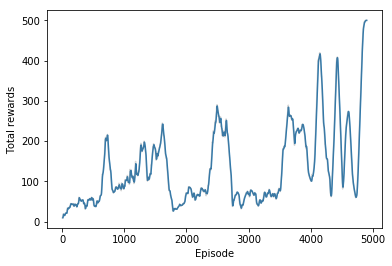

In [33]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

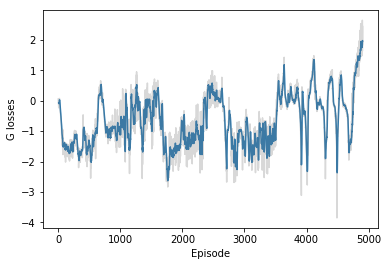

In [34]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

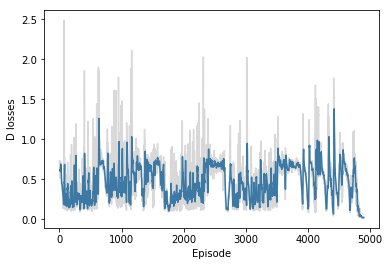

In [35]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses R')

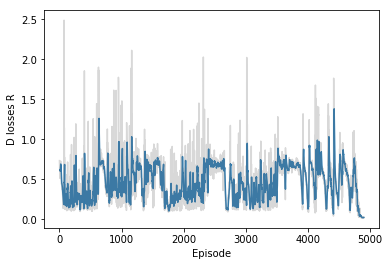

In [36]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

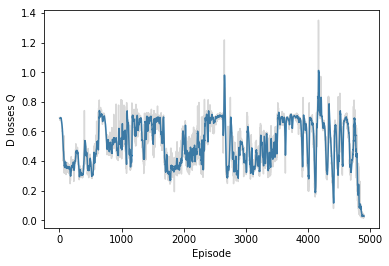

In [37]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.